# Environment

In [1]:
import numpy as np  
import pandas as pd
from numpy import median, percentile
from numpy.random import seed, randint
 
from sklearn import metrics
#from scipy.integrate import cumtrapz
from sklearn.metrics import (roc_auc_score, cohen_kappa_score,confusion_matrix, precision_score,
                             accuracy_score, average_precision_score, f1_score,
                             precision_recall_curve, roc_curve) #, auc, recall_score)
import matplotlib.pyplot as pyplot              
from inspect import signature
import joblib
from sklearn.calibration import (CalibratedClassifierCV, 
                                 _CalibratedClassifier, calibration_curve)  
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (make_scorer, roc_auc_score) #, cohen_kappa_score,confusion_matrix, precision_score,
#                             accuracy_score, auc, average_precision_score, f1_score,
#                             precision_recall_curve, recall_score, roc_curve)          
import dill
import sys
from xgboost import XGBClassifier

# STS Threshold analysis

# Defining functions

## Specificity and Sensitivity

In [2]:
def spec(y_true,y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true,y_pred).ravel()
    return TN/(TN+FP)   

def sens(y_true,y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true,y_pred).ravel()
    return TP/(TP+FN)   

## Optimal AUC threshold

In [3]:
def optimal_threshold_auc(target, predicted):
 
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold'])

## AUROC

In [4]:
def auroc(y, ypred,title):
    fig = pyplot.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    fpr, tpr, thresholds = roc_curve(y, ypred)
    auc_score = roc_auc_score(y, ypred)

    pyplot.plot([0, 1], [0, 1], linestyle='--')
    pyplot.plot(fpr, tpr, marker='.',color='c')
    pyplot.xlabel('False positive rate')
    pyplot.ylabel('Recall')
    pyplot.ylim([0.0, 1.05])
    pyplot.xlim([0.0, 1.0])
    pyplot.title(title+' '+'AUROC={0:0.2f}'.format(auc_score)) 
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

## AUPR

In [5]:
def aupr(y, ypred,title):
    fig = pyplot.figure(figsize=(8,5))
    ax = fig.add_subplot(111)

    Baseline = sum(y)/len(y)
    average_precision = metrics.average_precision_score(y, ypred)
    
    precision, recall, _ = precision_recall_curve(y, ypred)
    auc = metrics.auc(recall, precision)
    step_kwargs = ({'step': 'post'}
    if 'step' in signature(pyplot.fill_between).parameters
    else {})
    pyplot.step(recall, precision, color='c', where='post')
    pyplot.fill_between(recall, precision, color='c', **step_kwargs)
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.ylim([0.0, 1.05])
    pyplot.xlim([0.0, 1.0])
    pyplot.title(title+' '+'AUPRC={0:0.2f}'.format(auc))
#    pyplot.plot(Baseline, 'b-',label='Baseline')
#    pyplot.legend(bbox_to_anchor=(0.7, 0.9), loc=2, borderaxespad=0., fontsize = 16)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20) 
        
        
def metric_aupr(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    auc = metrics.auc(recall, precision)
    return auc        

## Bootstrapping function

In [6]:
def metric_SMR(y_true, y_pred):
   SMR = sum(y_pred)/sum(y_true)
   return SMR

def get_CI_boot(y_true,y_pred,metric,boot):
    # bootstrap confidence intervals
    # seed the random number generator
    seed(1)
    i = 0
    # generate dataset
    dataset = y_pred
    real = y_true
    # bootstrap
    scores = list()
    while i < boot:
        # bootstrap sample
        indices = randint(0, len(y_pred) - 1, len(y_pred))
        sample = dataset[indices]
        real = y_true[indices]
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
    	# calculate and store statistic 
        else:
            statistic = metric(real,sample)
            scores.append(statistic)
            i += 1
    
    # calculate 95% confidence intervals (100 - alpha)
    alpha = 5.0
    # calculate lower percentile (e.g. 2.5)
    lower_p = alpha / 2.0
    # retrieve observation at lower percentile
    lower = max(0.0, percentile(scores, lower_p))
    # calculate upper percentile (e.g. 97.5)
    upper_p = (100 - alpha) + (alpha / 2.0)
    # retrieve observation at upper percentile
    if metric == metric_SMR:
        upper = percentile(scores, upper_p)
    else:
        upper = min(1.0, percentile(scores, upper_p))
    delta = upper-lower
    mediana = median(scores)
    return mediana,(lower,upper),delta

## Importing the STS_threshold train and test datasets

In [7]:
# Import
train_ststheshold = pd.read_csv("../../data/train.csv", delimiter=",", low_memory=False) # ../../ go two folders back from current location

test_ststheshold = pd.read_csv("../../data/test.csv", delimiter=",", low_memory=False)

cols = [ '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399', '400', '401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '440', '441', '442', '443', '444', '445', '446', '447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472', '473', '474', '475', '476', '477', '478', '479', '480', '481', '482', '483', '484', '485', '486', '487', '488', '489', '490', '491', '492', '493', '494', '495', '496', '497', '498', '499', '500', '501', '502', '503', '504', '505', '506', '507', '508', '509', '510', '511', '512', '513', '514', '515', '516', '517', '518', '519', '520', '521', '522', '523', '524', '525', '526', '527', '528', '529', '530', '531', '532', '533', '534', '535', '536', '537', '538', '539', '540', '541', '542', '543', '544', '545', '546', '547', '548', '549', '550', '551', '552', '553', '554', '555', '556', '557', '558', '559', '560', '561', '562', '563', '564', '565', '566', '567', '568', '569', '570', '571', '572', '573', '574', '575', '576', '577', '578', '579', '580', '581', '582', '583', '584', '585', '586', '587', '588', '589', '590', '591', '592', '593', '594', '595', '596', '597', '598', '599', '600', '601', '602', '603', '604', '605', '606', '607', '608', '609', '610', '611', '612', '613', '614', '615', '616', '617', '618', '619', '620', '621', '622', '623', '624', '625', '626', '627', '628', '629', '630', '631', '632', '633', '634', '635', '636', '637', '638', '639', '640', '641', '642', '643', '644', '645', '646', '647', '648', '649', '650', '651', '652', '653', '654', '655', '656', '657', '658', '659', '660', '661', '662', '663', '664', '665', '666', '667', '668', '669', '670', '671', '672', '673', '674', '675', '676', '677', '678', '679', '680', '681', '682', '683', '684', '685', '686', '687', '688', '689', '690', '691', '692', '693', '694', '695', '696', '697', '698', '699', '700', '701', '702', '703', '704', '705', '706', '707', '708', '709', '710', '711', '712', '713', '714', '715', '716', '717', '718', '719', '720', '721', '722', '723', '724', '725', '726', '727', '728', '729', '730', '731', '732', '733', '734', '735', '736', '737', '738', '739', '740', '741', '742', '743', '744', '745', '746', '747', '748', '749', '750', '751', '752', '753', '754', '755', '756', '757', '758', '759', '760', '761', '762', '763', '764', '765', '766', '767', '768', '769', '770', '771', '772', '773', '774', '775', '776', '777', '778', '779', '780', '781', '782', '783', '784', '785', '786', '787', '788', '789', '790', '791', '792', '793', '794', '795', '796', '797', '798', '799', '800', '801', '802', '803', '804', '805', '806', '807', '808', '809', '810', '811', '812', '813', '814', '815', '816', '817', '818', '819', '820', '821', '822', '823', '824', '825', '826', '827', '828', '829', '830', '831', '832', '833', '834', '835', '836', '837', '838', '839', '840', '841', '842', '843', '844', '845', '846', '847', '848', '849', '850', '851', '852', '853', '854', '855', '856', '857', '858', '859', '860', '861', '862', '863', '864', '865', '866', '867', '868', '869', '870', '871', '872', '873', '874', '875', '876', '877', '878', '879', '880', '881', '882', '883', '884', '885', '886', '887', '888', '889', '890', '891', '892', '893', '894', '895', '896', '897', '898', '899', '900', '901', '902', '903', '904', '905', '906', '907', '908', '909', '910', '911', '912', '913', '914', '915', '916', '917', '918', '919', '920', '921', '922', '923', '924', '925', '926', '927', '928', '929', '930', '931', '932', '933', '934', '935', '936', '937', '938', '939', '940', '941', '942', '943', '944', '945', '946', '947', '948', '949', '950', '951', '952', '953', '954', '955', '956', '957', '958', '959', '960', '961', '962', '963', '964', '965', '966', '967', '968', '969', '970', '971', '972', '973', '974', '975', '976', '977', '978', '979', '980', '981', '982', '983', '984', '985', '986', '987', '988', '989', '990', '991', '992', '993', '994', '995', '996', '997', '998', '999', '1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '1059', '1060', '1061', '1062', '1063', '1064', '1065', '1066', '1067', '1068', '1069', '1070', '1071', '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079', '1080', '1081', '1082', '1083', '1084', '1085', '1086', '1087', '1088', '1089', '1090', '1091', '1092', '1093', '1094', '1095', '1096', '1097', '1098', '1099', '1100', '1101', '1102', '1103', '1104', '1105', '1106', '1107', '1108', '1109', '1110', '1111', '1112', '1113', '1114', '1115', '1116', '1117', '1118', '1119', '1120', '1121', '1122', '1123', '1124', '1125', '1126', '1127', '1128', '1129', '1130', '1131', '1132', '1133', '1134', '1135', '1136', '1137', '1138', '1139', '1140', '1141', '1142', '1143', '1144', '1145', '1146', '1147', '1148', '1149', '1150', '1151', '1152', '1153', '1154', '1155', '1156', '1157', '1158', '1159', '1160', '1161', '1162', '1163', '1164', '1165', '1166', '1167', '1168', '1169', '1170', '1171', '1172', '1173', '1174', '1175', '1176', '1177', '1178', '1179', '1180', '1181', '1182', '1183', '1184', '1185', '1186', '1187', '1188', '1189', '1190', '1191', '1192', '1193', '1194', '1195', '1196', '1197', '1198', '1199', '1200', '1201', '1202', '1203', '1204', '1205', '1206', '1207', '1208', '1209', '1210', '1211', '1212', '1213', '1214', '1215', '1216', '1217', '1218', '1219', '1220', '1221', '1222', '1223', '1224', '1225', '1226', '1227', '1228', '1229', '1230', '1231', '1232', '1233', '1234', '1235', '1236', '1237', '1238', '1239', '1240', '1241', '1242', '1243', '1244', '1245', '1246', '1247', '1248', '1249', '1250', '1251', '1252', '1253', '1254', '1255', '1256', '1257', '1258', '1259', '1260', '1261', '1262', '1263', '1264', '1265', '1266', '1267', '1268', '1269', '1270', '1271', '1272', '1273', '1274', '1275', '1276', '1277', '1278', '1279', '1280', '1281', '1282', '1283', '1284', '1285', '1286', '1287', '1288', '1289', '1290', '1291', '1292', '1293', '1294', '1295', '1296', '1297', '1298', '1299', '1300', '1301', '1302', '1303', '1304', '1305', '1306', '1307', '1308', '1309', '1310', '1311', '1312', '1313', '1314', '1315', '1316', '1317', '1318', '1319', '1320', '1321', '1322', '1323', '1324', '1325', '1326', '1327', '1328', '1329', '1330', '1331', '1332', '1333', '1334', '1335', '1336', '1337', '1338', '1339', '1340', '1341', '1342', '1343', '1344', '1345', '1346', '1347', '1348', '1349', '1350', '1351', '1352', '1353', '1354', '1355', '1356', '1357', '1358', '1359', '1360', '1361', '1362', '1363', '1364', '1365', '1366', '1367', '1368', '1369', '1370', '1371', '1372', '1373', '1374', '1375', '1376', '1377', '1378', '1379', '1380', '1381', '1382', '1383', '1384', '1385', '1386', '1387', '1388', '1389', '1390', '1391', '1392', '1393', '1394', '1395', '1396', '1397', '1398', '1399', '1400', '1401', '1402', '1403', '1404', '1405', '1406', '1407', '1408', '1409', '1410', '1411', '1412', '1413', '1414', '1415', '1416', '1417', '1418', '1419', '1420', '1421', '1422', '1423', '1424', '1425', '1426', '1427', '1428', '1429', '1430', '1431', '1432', '1433', '1434', '1435', '1436', '1437', '1438', '1439', '1440', '1441', '1442', '1443', '1444', '1445', '1446', '1447', '1448', '1449', '1450', '1451', '1452', '1453', '1454', '1455', '1456', '1457', '1458', '1459', '1460', '1461', '1462', '1463', '1464', '1465', '1466', '1467', '1468', '1469', '1470', '1471', '1472', '1473', '1474', '1475', '1476', '1477', '1478', '1479', '1480', '1481', '1482', '1483', '1484', '1485', '1486', '1487', '1488', '1489', '1490', '1491', '1492', '1493', '1494', '1495', '1496', '1497', '1498', '1499', '1500', '1501', '1502', '1503', '1504', '1505', '1506', '1507', '1508', '1509', '1510', '1511', '1512', '1513', '1514', '1515', '1516', '1517', '1518', '1519', '1520', '1521', '1522', '1523', '1524', '1525', '1526', '1527', '1528', '1529', '1530', '1531', '1532', '1533', '1534', '1535', '1536', '1537', '1538', '1539', '1540', '1541', '1542', '1543', '1544', '1545', '1546', '1547', '1548', '1549', '1550', '1551', '1552', '1553', '1554', '1555', '1556', '1557', '1558', '1559', '1560', '1561', '1562', '1563', '1564', '1565', '1566', '1567', '1568', '1569', '1570', '1571', '1572', '1573', '1574', '1575', '1576', '1577', '1578', '1579', '1580', '1581', '1582', '1583', '1584', '1585', '1586', '1587', '1588', '1589', '1590', '1591', '1592', '1593', '1594', '1595', '1596', '1597', '1598', '1599', '1600', '1601', '1602', '1603', '1604', '1605', '1606', '1607', '1608', '1609', '1610', '1611', '1612', '1613', '1614', '1615', '1616', '1617', '1618', '1619', '1620', '1621', '1622', '1623', '1624', '1625', '1626', '1627', '1628', '1629', '1630', '1631', '1632', '1633', '1634', '1635', '1636', '1637', '1638', '1639', '1640', '1641', '1642', '1643', '1644', '1645', '1646', '1647', '1648', '1649', '1650', '1651', '1652', '1653', '1654', '1655', '1656', '1657', '1658', '1659', '1660', '1661', '1662', '1663', '1664', '1665', '1666', '1667', '1668', '1669', '1670', '1671', '1672', '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681', '1682', '1683', '1684', '1685', '1686', '1687', '1688', '1689', '1690', '1691', '1692', '1693', '1694', '1695', '1696', '1697', '1698', '1699', '1700', '1701', '1702', '1703', '1704', '1705', '1706', '1707', '1708', '1709', '1710', '1711', '1712', '1713', '1714', '1715', '1716', '1717', '1718', '1719', '1720', '1721', '1722', '1723', '1724', '1725', '1726', '1727', '1728', '1729', '1730', '1731', '1732', '1733', '1734', '1735', '1736', '1737', '1738', '1739', '1740', '1741', '1742', '1743', '1744', '1745', '1746', '1747', '1748', '1749', '1750', '1751', '1752', '1753', '1754', '1755', '1756', '1757', '1758', '1759', '1760', '1761', '1762', '1763', '1764', '1765', '1766', '1767', '1768', '1769', '1770', '1771', '1772', '1773', '1774', '1775', '1776', '1777', '1778', '1779', '1780', '1781', '1782', '1783', '1784', '1785', '1786', '1787', '1788', '1789', '1790', '1791', '1792', '1793', '1794', '1795', '1796', '1797', '1798', '1799', '1800', '1801', '1802', '1803', '1804', '1805', '1806', '1807', '1808', '1809', '1810', '1811', '1812', '1813', '1814', '1815', '1816', '1817', '1818', '1819', '1820', '1821', '1822', '1823', '1824', '1825', '1826', '1827', '1828', '1829', '1830', '1831', '1832', '1833', '1834', '1835', '1836', '1837', '1838', '1839', '1840', '1841', '1842', '1843', '1844', '1845', '1846', '1847', '1848', '1849', '1850', '1851', '1852', '1853', '1854', '1855', '1856', '1857', '1858', '1859', '1860', '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868', '1869', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1880', '1881', '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889', '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050', '2051', '2052', '2053', '2054', '2055', '2056', '2057', '2058', '2059', '2060', '2061', '2062', '2063', '2064', '2065', '2066', '2067', '2068', '2069', '2070', '2071', '2072', '2073', '2074', '2075', '2076', '2077', '2078', '2079', '2080', '2081', '2082', '2083', '2084', '2085', '2086', '2087', '2088', '2089', '2090', '2091', '2092', '2093', '2094', '2095', '2096', '2097', '2098', '2099', '2100', '2101', '2102', '2103', '2104', '2105', '2106', '2107', '2108', '2109', '2110', '2111', '2112', '2113', '2114', '2115', '2116', '2117', '2118', '2119', '2120', '2121', '2122', '2123', '2124', '2125', '2126', '2127', '2128', '2129', '2130', '2131', '2132', '2133', '2134', '2135', '2136', '2137', '2138', '2139', '2140', '2141', '2142', '2143', '2144', '2145', '2146', '2147', '2148', '2149', '2150', '2151', '2152', '2153', '2154', '2155', '2156', '2157', '2158', '2159', '2160', '2161', '2162', '2163', '2164', '2165', '2166', '2167', '2168', '2169', '2170', '2171', '2172', '2173', '2174', '2175', '2176', '2177', '2178', '2179', '2180', '2181', '2182', '2183', '2184', '2185', '2186', '2187', '2188', '2189', '2190', '2191', '2192', '2193', '2194', '2195', '2196', '2197', '2198', '2199', '2200', '2201', '2202', '2203', '2204', '2205', '2206', '2207', '2208', '2209', '2210', '2211', '2212', '2213', '2214', '2215', '2216', '2217', '2218', '2219', '2220', '2221', '2222', '2223', '2224', '2225', '2226', '2227', '2228', '2229', '2230', '2231', '2232', '2233', '2234', '2235', '2236', '2237', '2238', '2239', '2240', '2241', '2242', '2243', '2244', '2245', '2246', '2247', '2248', '2249', '2250', '2251', '2252', '2253', '2254', '2255', '2256', '2257', '2258', '2259', '2260', '2261', '2262', '2263', '2264', '2265', '2266', '2267', '2268', '2269', '2270', '2271', '2272', '2273', '2274', '2275', '2276', '2277', '2278', '2279', '2280', '2281', '2282', '2283', '2284', '2285', '2286', '2287', '2288', '2289', '2290', '2291', '2292', '2293', '2294', '2295', '2296', '2297', '2298', '2299', '2300', '2301', '2302', '2303', '2304', '2305', '2306', '2307', '2308', '2309', '2310', '2311', '2312', '2313', '2314', '2315', '2316', '2317', '2318', '2319', '2320', '2321', '2322', '2323', '2324', '2325', '2326', '2327', '2328', '2329', '2330', '2331', '2332', '2333', '2334', '2335', '2336', '2337', '2338', '2339', '2340', '2341', '2342', '2343', '2344', '2345', '2346', '2347', '2348', '2349', '2350', '2351', '2352', '2353', '2354', '2355', '2356', '2357', '2358', '2359', '2360', '2361', '2362', '2363', '2364', '2365', '2366', '2367', '2368', '2369', '2370', '2371', '2372', '2373', '2374', '2375', '2376', '2377', '2378', '2379', '2380', '2381', '2382', '2383', '2384', '2385', '2386', '2387', '2388', '2389', '2390', '2391', '2392', '2393', '2394', '2395', '2396', '2397', '2398', '2399', '2400', '2401', '2402', '2403', '2404', '2405', '2406', '2407', '2408', '2409', '2410', '2411', '2412', '2413', '2414', '2415', '2416', '2417', '2418', '2419', '2420', '2421', '2422', '2423', '2424', '2425', '2426', '2427', '2428', '2429', '2430', '2431', '2432', '2433', '2434', '2435', '2436', '2437', '2438', '2439', '2440', '2441', '2442', '2443', '2444', '2445', '2446', '2447', '2448', '2449', '2450', '2451', '2452', '2453', '2454', '2455', '2456', '2457', '2458', '2459', '2460', '2461', '2462', '2463', '2464', '2465', '2466', '2467', '2468', '2469', '2470', '2471', '2472', '2473', '2474', '2475', '2476', '2477', '2478', '2479', '2480', '2481', '2482', '2483', '2484', '2485', '2486', '2487', '2488', '2489', '2490', '2491', '2492', '2493', '2494', '2495', '2496', '2497', '2498', '2499', '2500', '2501', '2502', '2503', '2504', '2505', '2506', '2507', '2508', '2509', '2510', '2511', '2512', '2513', '2514', '2515', '2516', '2517', '2518', '2519', '2520', '2521', '2522', '2523', '2524', '2525', '2526', '2527', '2528', '2529', '2530', '2531', '2532', '2533', '2534', '2535', '2536', '2537', '2538', '2539', '2540', '2541', '2542', '2543', '2544', '2545', '2546', '2547', '2548', '2549', '2550', '2551', '2552', '2553', '2554', '2555', '2556', '2557', '2558', '2559', '2560', '2561', '2562', '2563', '2564', '2565', '2566', '2567', '2568', '2569', '2570', '2571', '2572', '2573', '2574', '2575', '2576', '2577', '2578', '2579', '2580', '2581', '2582', '2583', '2584', '2585', '2586', '2587', '2588', '2589', '2590', '2591', '2592', '2593', '2594', '2595', '2596', '2597', '2598', '2599', '2600', '2601', '2602', '2603', '2604', '2605', '2606', '2607', '2608', '2609', '2610', '2611', '2612', '2613', '2614', '2615', '2616', '2617', '2618', '2619', '2620', '2621', '2622', '2623', '2624', '2625', '2626', '2627', '2628', '2629', '2630', '2631', '2632', '2633', '2634', '2635', '2636', '2637', '2638', '2639', '2640', '2641', '2642', '2643', '2644', '2645', '2646', '2647', '2648', '2649', '2650', '2651', '2652', '2653', '2654', '2655', '2656', '2657', '2658', '2659', '2660', '2661', '2662', '2663', '2664', '2665', '2666', '2667', '2668', '2669', '2670', '2671', '2672', '2673', '2674', '2675', '2676', '2677', '2678', '2679', '2680', '2681', '2682', '2683', '2684', '2685', '2686', '2687', '2688', '2689', '2690', '2691', '2692', '2693', '2694', '2695', '2696', '2697', '2698', '2699', '2700', '2701', '2702', '2703', '2704', '2705', '2706', '2707', '2708', '2709', '2710', '2711', '2712', '2713', '2714', '2715', '2716', '2717', '2718', '2719', '2720', '2721', '2722', '2723', '2724', '2725', '2726', '2727', '2728', '2729', '2730', '2731', '2732', '2733', '2734', '2735', '2736', '2737', '2738', '2739', '2740', '2741', '2742', '2743', '2744', '2745', '2746', '2747', '2748', '2749', '2750', '2751', '2752', '2753', '2754', '2755', '2756', '2757', '2758', '2759', '2760', '2761', '2762', '2763', '2764', '2765', '2766', '2767', '2768', '2769', '2770', '2771', '2772', '2773', '2774', '2775', '2776', '2777', '2778', '2779', '2780', '2781', '2782', '2783', '2784', '2785', '2786', '2787', '2788', '2789', '2790', '2791', '2792', '2793', '2794', '2795', '2796', '2797', '2798', '2799', '2800', '2801', '2802', '2803', '2804', '2805', '2806', '2807', '2808', '2809', '2810', '2811', '2812', '2813', '2814', '2815', '2816', '2817', '2818', '2819', '2820', '2821', '2822', '2823', '2824', '2825', '2826', '2827', '2828', '2829', '2830', '2831', '2832', '2833', '2834', '2835', '2836', '2837', '2838', '2839', '2840', '2841', '2842', '2843', '2844', '2845', '2846', '2847', '2848', '2849', '2850', '2851', '2852', '2853', '2854', '2855', '2856', '2857', '2858', '2859', '2860', '2861', '2862', '2863', '2864', '2865', '2866', '2867', '2868', '2869', '2870', '2871', '2872', '2873', '2874', '2875', '2876', '2877', '2878', '2879', '2880', '2881', '2882', '2883', '2884', '2885', '2886', '2887', '2888', '2889', '2890', '2891', '2892', '2893', '2894', '2895', '2896', '2897', '2898', '2899', '2900', '2901', '2902', '2903', '2904', '2905', '2906', '2907', '2908', '2909', '2910', '2911', '2912', '2913', '2914', '2915', '2916', '2917', '2918', '2919', '2920', '2921', '2922', '2923', '2924', '2925', '2926', '2927', '2928', '2929', '2930', '2931', '2932', '2933', '2934', '2935', '2936', '2937', '2938', '2939', '2940', '2941', '2942', '2943', '2944', '2945', '2946', '2947', '2948', '2949', '2950', '2951', '2952', '2953', '2954', '2955', '2956', '2957', '2958', '2959', '2960', '2961', '2962', '2963', '2964', '2965', '2966', '2967', '2968', '2969', '2970', '2971', '2972', '2973', '2974', '2975', '2976', '2977', '2978', '2979', '2980', '2981', '2982', '2983', '2984', '2985', '2986', '2987', '2988', '2989', '2990', '2991', '2992', '2993', '2994', '2995', '2996', '2997', '2998', '2999', '3000', '3001', '3002', '3003', '3004', '3005', '3006', '3007', '3008', '3009', '3010', '3011', '3012', '3013', '3014', '3015', '3016', '3017', '3018', '3019', '3020', '3021', '3022', '3023', '3024', '3025', '3026', '3027', '3028', '3029', '3030', '3031', '3032', '3033', '3034', '3035', '3036', '3037', '3038', '3039', '3040', '3041', '3042', '3043', '3044', '3045', '3046', '3047', '3048', '3049', '3050', '3051', '3052', '3053', '3054', '3055', '3056', '3057', '3058', '3059', '3060', '3061', '3062', '3063', '3064', '3065', '3066', '3067', '3068', '3069', '3070', '3071', '3072', '3073', '3074', '3075', '3076', '3077', '3078', '3079', '3080', '3081', '3082', '3083', '3084', '3085', '3086', '3087', '3088', '3089', '3090', '3091', '3092', '3093', '3094', '3095', '3096', '3097', '3098', '3099', '3100', '3101', '3102', '3103', '3104', '3105', '3106', '3107', '3108', '3109', '3110', '3111', '3112', '3113', '3114', '3115', '3116', '3117', '3118', '3119', '3120', '3121', '3122', '3123', '3124', '3125', '3126', '3127', '3128', '3129', '3130', '3131', '3132', '3133', '3134', '3135', '3136', '3137', '3138', '3139', '3140', '3141', '3142', '3143', '3144', '3145', '3146', '3147', '3148', '3149', '3150', '3151', '3152', '3153', '3154', '3155', '3156', '3157', '3158', '3159', '3160', '3161', '3162', '3163', '3164', '3165', '3166', '3167', '3168', '3169', '3170', '3171', '3172', '3173', '3174', '3175', '3176', '3177', '3178', '3179', '3180', '3181', '3182', '3183', '3184', '3185', '3186', '3187', '3188', '3189', '3190', '3191', '3192', '3193', '3194', '3195', '3196', '3197', '3198', '3199', '3200', '3201', '3202', '3203', '3204', '3205', '3206', '3207', '3208', '3209', '3210', '3211', '3212', '3213', '3214', '3215', '3216', '3217', '3218', '3219', '3220', '3221', '3222', '3223', '3224', '3225', '3226', '3227', '3228', '3229', '3230', '3231', '3232', '3233', '3234', '3235', '3236', '3237', '3238', '3239', '3240', '3241', '3242', '3243', '3244', '3245', '3246', '3247', '3248', '3249', '3250', '3251', '3252', '3253', '3254', '3255', '3256', '3257', '3258', '3259', '3260', '3261', '3262', '3263', '3264', '3265', '3266', '3267', '3268', '3269', '3270', '3271', '3272', '3273', '3274', '3275', '3276', '3277', '3278', '3279', '3280', '3281', '3282', '3283', '3284', '3285', '3286', '3287', '3288', '3289', '3290', '3291', '3292', '3293',
        'entropy',
        'Gender', 'Age', 'Category', 'duration_Surgery_min', 'duration_CPB_min', 'duration_outsideCPB_min', 
        'STS_RiskAlgorithm_multiple_imp', 'STS_RiskAlgorithm_median_imp', 'total_pressors_formula_mg',
        'Q_total_pressors_formula_mg', 'T_STS_RiskAlgorithm_median_imp', 'T_STS_RiskAlgorithm_multiple_imp',
        'Q_AUC65MAP_total_mmHgmin', 'Q_TWA65MAP_total_mmHg', 'Q_AUC65MAP_CPB_mmHgmin', 'Q_AUC65MAP_outsideCPB_mmHgmin',
        'Q_TWA65MAP_CPB_mmHg', 'Q_TWA65MAP_outsideCPB_mmHg', 'TWA65MAP_total_mmHg', 'TWA65MAP_CPB_mmHg', 'TWA65MAP_outsideCPB_mmHg',
        'delta_HCT_pct_median_imp', 'mean_ef_median_imp', 'Cross_Clamp_Time_imp', 'AUC65MAP_total_mmHgmin', 'AUC65MAP_CPB_mmHgmin',
        'duration_preCPB_min', 'duration_postCPB_min', 'TWA65MAP_preCPB_mmHg', 'TWA65MAP_postCPB_mmHg', 'AUC65MAP_preCPB_mmHgmin', 'AUC65MAP_postCPB_mmHgmin', 
        'AUC65MAP_outsideCPB_mmHgmin', 'Any_MAE', 'Renal_Failure','Stroke', 'RFDS', 'RFD', 'DS', 'RFS', 'id']


train_ststheshold = train_ststheshold.drop(columns = cols)
test_ststheshold = test_ststheshold.drop(columns = cols)

train_ststheshold  = pd.DataFrame.dropna(train_ststheshold)
test_ststheshold  = pd.DataFrame.dropna(test_ststheshold)

# Defining the ststhreshold_five to consider a patient is likely to die

train_ststhreshold_five  = pd.DataFrame.dropna(train_ststheshold)
test_ststhreshold_five  = pd.DataFrame.dropna(test_ststheshold)

def f(row):
    if row['STS_RiskAlgorithm'] < 0.05 :
        val = 0
    else:
        val = 1
    return val

train_ststhreshold_five['STS_threshold_pred'] = train_ststhreshold_five.apply(f, axis=1)
test_ststhreshold_five['STS_threshold_pred'] = test_ststhreshold_five.apply(f, axis=1)

## Split data into x y training and x y test sets

y_train_ststhreshold_five = train_ststhreshold_five['Death']
X_train_ststhreshold_five = train_ststhreshold_five.drop(columns = ['Death'])
    
y_test_ststhreshold_five = test_ststhreshold_five['Death']
X_test_ststhreshold_five = test_ststhreshold_five.drop(columns = ['Death'])

# All    

X_num_ststhreshold_five = X_train_ststhreshold_five

get_numeric_data_ststhreshold_five = FunctionTransformer(lambda x: x[X_num_ststhreshold_five.columns], validate=False)

get_categorical_ststhreshold_five = FunctionTransformer(lambda x: x[[]], validate=False) 

scaler_ststhreshold_five = MinMaxScaler()

num_pipe_ststhreshold_five = Pipeline([
  ('select_num', get_numeric_data_ststhreshold_five),
  ('scale', scaler_ststhreshold_five)
  ])

cat_pipe_ststhreshold_five = Pipeline([
  ('select_cat', get_categorical_ststhreshold_five)
  ])

## Predictions in train and test

y_train_pred_ststhreshold_five = train_ststhreshold_five['STS_threshold_pred']
y_test_pred_ststhreshold_five = test_ststhreshold_five['STS_threshold_pred']
y_test_pred_ststhreshold_five = np.array(y_test_pred_ststhreshold_five)

# Defining the ststhreshold_eight to consider a patient is likely to die

train_ststhreshold_eight  = pd.DataFrame.dropna(train_ststheshold)
test_ststhreshold_eight  = pd.DataFrame.dropna(test_ststheshold)

def f(row):
    if row['STS_RiskAlgorithm'] < 0.08 :
        val = 0
    else:
        val = 1
    return val

train_ststhreshold_eight['STS_threshold_pred'] = train_ststhreshold_eight.apply(f, axis=1)
test_ststhreshold_eight['STS_threshold_pred'] = test_ststhreshold_eight.apply(f, axis=1)

## Split data into x y training and x y test sets

y_train_ststhreshold_eight = train_ststhreshold_eight['Death']
X_train_ststhreshold_eight = train_ststhreshold_eight.drop(columns = ['Death'])
    
y_test_ststhreshold_eight = test_ststhreshold_eight['Death']
X_test_ststhreshold_eight = test_ststhreshold_eight.drop(columns = ['Death'])

# All    

X_num_ststhreshold_eight = X_train_ststhreshold_eight

get_numeric_data_ststhreshold_eight = FunctionTransformer(lambda x: x[X_num_ststhreshold_eight.columns], validate=False)

get_categorical_ststhreshold_eight = FunctionTransformer(lambda x: x[[]], validate=False) 

scaler_ststhreshold_eight = MinMaxScaler()

num_pipe_ststhreshold_eight = Pipeline([
  ('select_num', get_numeric_data_ststhreshold_eight),
  ('scale', scaler_ststhreshold_eight)
  ])

cat_pipe_ststhreshold_eight = Pipeline([
  ('select_cat', get_categorical_ststhreshold_eight)
  ])

## Predictions in train and test

y_train_pred_ststhreshold_eight = train_ststhreshold_eight['STS_threshold_pred']
y_test_pred_ststhreshold_eight = test_ststhreshold_eight['STS_threshold_pred']
y_test_pred_ststhreshold_eight = np.array(y_test_pred_ststhreshold_eight)

# Defining the ststhreshold_eleven to consider a patient is likely to die

train_ststhreshold_eleven  = pd.DataFrame.dropna(train_ststheshold)
test_ststhreshold_eleven  = pd.DataFrame.dropna(test_ststheshold)

def f(row):
    if row['STS_RiskAlgorithm'] < 0.11 :
        val = 0
    else:
        val = 1
    return val

train_ststhreshold_eleven['STS_threshold_pred'] = train_ststhreshold_eleven.apply(f, axis=1)
test_ststhreshold_eleven['STS_threshold_pred'] = test_ststhreshold_eleven.apply(f, axis=1)

## Split data into x y training and x y test sets

y_train_ststhreshold_eleven = train_ststhreshold_eleven['Death']
X_train_ststhreshold_eleven = train_ststhreshold_eleven.drop(columns = ['Death'])
    
y_test_ststhreshold_eleven = test_ststhreshold_eleven['Death']
X_test_ststhreshold_eleven = test_ststhreshold_eleven.drop(columns = ['Death'])

# All    

X_num_ststhreshold_eleven = X_train_ststhreshold_eleven

get_numeric_data_ststhreshold_eleven = FunctionTransformer(lambda x: x[X_num_ststhreshold_eleven.columns], validate=False)

get_categorical_ststhreshold_eleven = FunctionTransformer(lambda x: x[[]], validate=False) 

scaler_ststhreshold_eleven = MinMaxScaler()

num_pipe_ststhreshold_eleven = Pipeline([
  ('select_num', get_numeric_data_ststhreshold_eleven),
  ('scale', scaler_ststhreshold_eleven)
  ])

cat_pipe_ststhreshold_eleven = Pipeline([
  ('select_cat', get_categorical_ststhreshold_eleven)
  ])

## Predictions in train and test

y_train_pred_ststhreshold_eleven = train_ststhreshold_eleven['STS_threshold_pred']
y_test_pred_ststhreshold_eleven = test_ststhreshold_eleven['STS_threshold_pred']
y_test_pred_ststhreshold_eleven = np.array(y_test_pred_ststhreshold_eleven)

In [8]:
print(train_ststheshold.shape[0]+test_ststheshold.shape[0])

4107


In [9]:
print(list(train_ststheshold.columns))

['STS_RiskAlgorithm', 'Death']


In [10]:
## Optimal AUC threshold

In [11]:
def optimal_threshold_auc(target, predicted):
 
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold'])

### AUROC STS thresold dataset vs preCPB dataset

(0.0, 1.0)

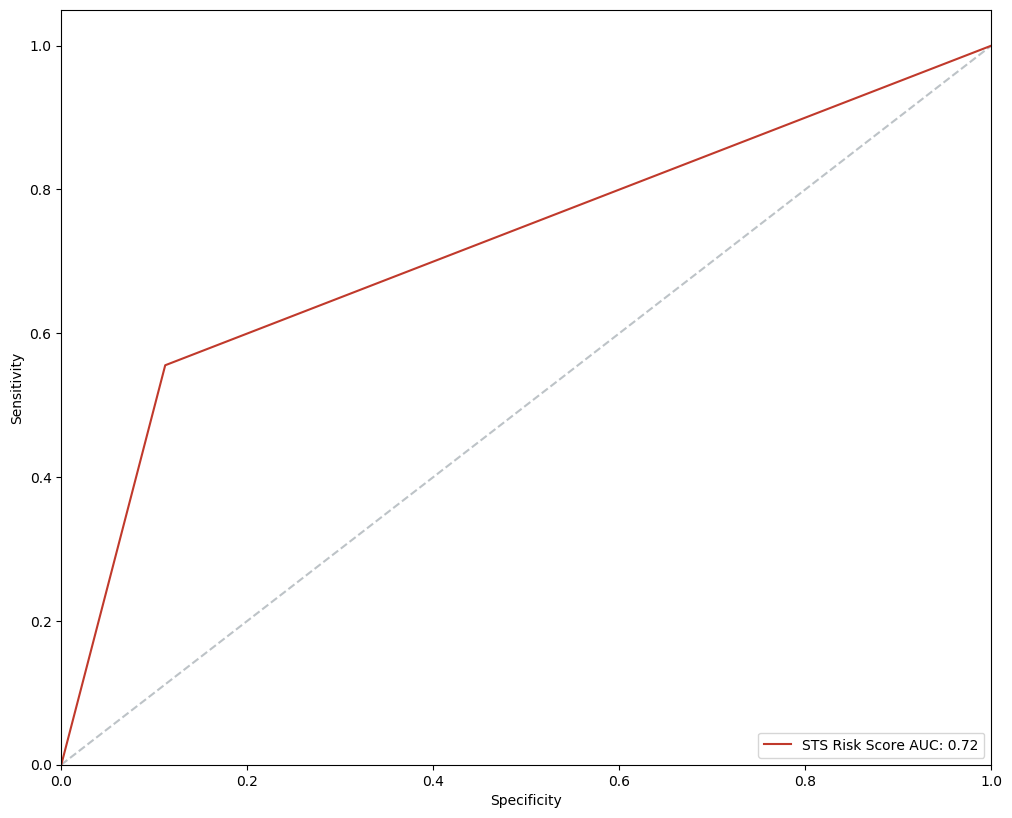

In [12]:
#  model1 (random forest) with all preCPB data
#model1 = bestmodels[1] # select the best performing model here
#y_train_pred_model1 = model1.predict_proba(X_train)[:,1]
#y_test_pred_model1 = model1.predict_proba(X_test)[:,1]
#fpr_model1, tpr_model1, thresholds_model1 = roc_curve(y_test, y_test_pred_model1)
#auc_score_model1 = roc_auc_score(y_test, y_test_pred_model1)

# predictions using ststhreshold_five data
y_train_pred_ststhreshold_five = train_ststhreshold_five['STS_threshold_pred']
y_test_pred_ststhreshold_five = test_ststhreshold_five['STS_threshold_pred']
y_test_pred_ststhreshold_five = np.array(y_test_pred_ststhreshold_five)
fpr_ststhreshold_five, tpr_ststhreshold_five, thresholds = roc_curve(y_test_ststhreshold_five, y_test_pred_ststhreshold_five)
auc_score_ststhreshold_five = roc_auc_score(y_test_ststhreshold_five, y_test_pred_ststhreshold_five)

my_dpi=100
pyplot.figure(figsize=(1200/my_dpi,1000/my_dpi), dpi=my_dpi)
pyplot.plot([0, 1], [0, 1], linestyle='--', color='#bdc3c7')

# AUROC postCPB model1
#pyplot.plot(fpr_model1, tpr_model1, marker='',color='#3498db',label='pre CPB RF AUC:'+' '+'{0:0.2f}'.format(auc_score_model1))

## AUROC STS Risk Score 
#AUC ststhreshold_five
pyplot.plot(fpr_ststhreshold_five, tpr_ststhreshold_five, marker='',color='#c0392b',label='STS Risk Score AUC:'+' '+'{0:0.2f}'.format(auc_score_ststhreshold_five))



pyplot.legend(loc='lower right')
pyplot.xlabel('Specificity')
pyplot.ylabel('Sensitivity')
pyplot.ylim([0.0, 1.05])
pyplot.xlim([0.0, 1.0])




In [13]:
bestmodels[1]

NameError: name 'bestmodels' is not defined

### Insights STS model

In [14]:
for i,model in enumerate(bestmodels):
    modelname = all_models_names[i]
    print(modelname)
    y_train_pred = model.predict_proba(X_train)[:,1]
    y_test_pred = model.predict_proba(X_test)[:,1]
    # Threshold in train
    threshold = optimal_threshold_auc(y_train, y_train_pred)
    
   # performance_all = [roc_auc_score,average_precision_score, accuracy_score, spec, 
   #                sens, precision_score, f1_score, cohen_kappa_score,metric_SMR,metric_aupr] 
   # 
   # performance_names_all = np.array(['roc_auc_score','average_precision_score'
   #                               ,' accuracy_score',' spec','sens',' precision_score'
   #                               ,' f1_score',' cohen_kappa_score','metric_SMR','metric_aupr'])
   # 
    performance = [roc_auc_score,average_precision_score, spec, sens] 
    
    performance_names = np.array(['roc_auc_score','precision_score','spec','sens'])
    
    
    conf = []
    delt = []
    met = []
    med = []
    te = []
    performance_insights = []
    
    y_test = np.array(y_test)
    
    for i,p in enumerate(performance):
        
        if (p == roc_auc_score or p == average_precision_score or p == metric_aupr):
            mediana,extremes,delta = get_CI_boot(y_test,y_test_pred,p,boot=100) #atencao aqui ao boot
            met.append(p)
            conf.append(extremes)
            delt.append(delta)
            med.append(mediana)
            te.append(p(y_test,y_test_pred)) 
            performance_insights.append(performance_names[i]+' '+str(round(p(y_test,y_test_pred), 2)) +' CI ['+ str(round(extremes[0], 2))  +'-'+  str(round(extremes[1], 2)) +']')
        else:
            y_pred_threshold = (y_test_pred >= threshold).astype(np.int)
            mediana,extremes,delta = get_CI_boot(y_test,y_pred_threshold,p,boot=100)
            met.append(p)
            conf.append(extremes)
            delt.append(delta)
            med.append(mediana)
            te.append(p(y_test,y_pred_threshold)) 
            performance_insights.append(performance_names[i]+' '+str(round(p(y_test,y_pred_threshold), 2)) +' CI ['+ str(round(extremes[0], 2))  +'-'+  str(round(extremes[1], 2)) +']')
            
    
    performance_insights =  str(performance_insights)
    performance_insights = performance_insights.replace("'", "")
    print(performance_insights)    

NameError: name 'bestmodels' is not defined

### AUPR STS thresold dataset vs preCPB dataset

In [15]:
# AUPRC 1
Baseline = sum(y_test)/len(y_test)
average_precision = metrics.average_precision_score(y_test, y_test_pred)
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
auc = metrics.auc(recall, precision)

step_kwargs = ({'step': 'post'}
if 'step' in signature(pyplot.fill_between).parameters
else {})


# AUPRC ststhreshold_five
Baseline_ststhreshold_five = sum(y_test_ststhreshold_five)/len(y_test_ststhreshold_five)
average_precision_ststhreshold_five = metrics.average_precision_score(y_test_ststhreshold_five, y_test_pred_ststhreshold_five)
precision_ststhreshold_five, recall_ststhreshold_five, _ = precision_recall_curve(y_test_ststhreshold_five, y_test_pred_ststhreshold_five)
auc_ststhreshold_five = metrics.auc(recall_ststhreshold_five, precision_ststhreshold_five)
step_kwargs_ststhreshold_five = ({'step': 'post'}
if 'step' in signature(pyplot.fill_between).parameters
else {})

# AUPRC ststhreshold_eight
Baseline_ststhreshold_eight = sum(y_test_ststhreshold_eight)/len(y_test_ststhreshold_eight)
average_precision_ststhreshold_eight = metrics.average_precision_score(y_test_ststhreshold_eight, y_test_pred_ststhreshold_eight)
precision_ststhreshold_eight, recall_ststhreshold_eight, _ = precision_recall_curve(y_test_ststhreshold_eight, y_test_pred_ststhreshold_eight)
auc_ststhreshold_eight = metrics.auc(recall_ststhreshold_eight, precision_ststhreshold_eight)
step_kwargs_ststhreshold_eight = ({'step': 'post'}
if 'step' in signature(pyplot.fill_between).parameters
else {})

# AUPRC ststhreshold_eleven
Baseline_ststhreshold_eleven = sum(y_test_ststhreshold_eleven)/len(y_test_ststhreshold_eleven)
average_precision_ststhreshold_eleven = metrics.average_precision_score(y_test_ststhreshold_eleven, y_test_pred_ststhreshold_eleven)
precision_ststhreshold_eleven, recall_ststhreshold_eleven, _ = precision_recall_curve(y_test_ststhreshold_eleven, y_test_pred_ststhreshold_eleven)
auc_ststhreshold_eleven = metrics.auc(recall_ststhreshold_eleven, precision_ststhreshold_eleven)
step_kwargs_ststhreshold_eleven = ({'step': 'post'}
if 'step' in signature(pyplot.fill_between).parameters
else {})

pyplot.figure(figsize=(1200/my_dpi,1000/my_dpi), dpi=my_dpi)
# AUPRC 1
pyplot.step(recall, precision, color='#27ae60',alpha=0.5, where='post')
pyplot.fill_between(recall, precision, color='#27ae60',alpha=0.5, **step_kwargs)

# AUPRC ststhreshold_five
pyplot.step(recall_ststhreshold_five, precision_ststhreshold_five, color='#c0392b',alpha=0.5, where='post')
pyplot.fill_between(recall_ststhreshold_five, precision_ststhreshold_five, color='#c0392b',alpha=0.5, **step_kwargs_ststhreshold_five)

# AUPRC ststhreshold_eight
pyplot.step(recall_ststhreshold_eight, precision_ststhreshold_eight, color='#e67e22',alpha=0.5, where='post')
pyplot.fill_between(recall_ststhreshold_eight, precision_ststhreshold_eight, color='#e67e22',alpha=0.5, **step_kwargs_ststhreshold_eight)

# AUPRC ststhreshold_eleven
pyplot.step(recall_ststhreshold_eleven, precision_ststhreshold_eleven, color='#f1c40f',alpha=0.5, where='post')
pyplot.fill_between(recall_ststhreshold_eleven, precision_ststhreshold_eleven, color='#f1c40f',alpha=0.5, **step_kwargs_ststhreshold_eleven)

pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.ylim([0.0, 1.05])
pyplot.xlim([0.0, 1.0])

# AUPRC 1
pyplot.plot(Baseline, 'b-',color='#27ae60',alpha=0.5,label='postCPB'+' '+'AUPRC={0:0.2f}'.format(auc))

# AUPRC ststhreshold_five
pyplot.plot(Baseline_ststhreshold_five, 'b-',color='#c0392b',alpha=0.5,label='STS Risk threshold 5% '+'AUPRC={0:0.2f}'.format(auc_ststhreshold_five))

# AUPRC ststhreshold_eight
pyplot.plot(Baseline_ststhreshold_eight, 'b-',color='#e67e22',alpha=0.5,label='STS Risk threshold 8% '+'AUPRC={0:0.2f}'.format(auc_ststhreshold_eight))

# AUPRC ststhreshold_eleven
pyplot.plot(Baseline_ststhreshold_eleven, 'b-',color='#f1c40f',alpha=0.5,label='STS Risk threshold 11% '+'AUPRC={0:0.2f}'.format(auc_ststhreshold_eleven))

pyplot.legend(loc='best')


NameError: name 'y_test' is not defined

### STS threshold Insights

In [16]:
# predictions using ststhreshold_five data
y_train_pred_ststhreshold_five = train_ststhreshold_five['STS_threshold_pred']
y_test_pred_ststhreshold_five = test_ststhreshold_five['STS_threshold_pred']
y_test_pred_ststhreshold_five = np.array(y_test_pred_ststhreshold_five)
fpr_ststhreshold_five, tpr_ststhreshold_five, thresholds = roc_curve(y_test_ststhreshold_five, y_test_pred_ststhreshold_five)
auc_score_ststhreshold_five = roc_auc_score(y_test_ststhreshold_five, y_test_pred_ststhreshold_five)


 
# Threshold in train
threshold = optimal_threshold_auc(y_train_ststhreshold_five, y_train_pred_ststhreshold_five)

performance = [roc_auc_score,average_precision_score, accuracy_score, spec, 
               sens, precision_score, f1_score, cohen_kappa_score,metric_SMR,metric_aupr] 

performance_names = np.array(['ROC AUC','Average Precision','Accuracy'
                              ,'Specificity','Sensitivity','Precision'
                              ,'F1','Cohen Kappa','SMR','AUPROC'])

conf = []
delt = []
met = []
med = []
te = []
performance_insights = []

y_test_ststhreshold_five = np.array(y_test_ststhreshold_five)

for i,p in enumerate(performance):
    
    if (p == roc_auc_score or p == average_precision_score or p == metric_aupr):
        mediana,extremes,delta = get_CI_boot(y_test_ststhreshold_five,y_test_pred_ststhreshold_five,p,boot=100) #atencao aqui ao boot
        met.append(p)
        conf.append(extremes)
        delt.append(delta)
        med.append(mediana)
        te.append(p(y_test_ststhreshold_five,y_test_pred_ststhreshold_five)) 
        performance_insights.append(
            performance_names[i]+
            ' '+str(round(p(y_test_ststhreshold_five,y_test_pred_ststhreshold_five), 2)) 
            +' CI ['+ str(round(extremes[0], 2))  +'-'+  str(round(extremes[1], 2)) +']'
        )
    else:
        y_pred_threshold = (y_test_pred_ststhreshold_five >= threshold).astype(np.int)
        mediana,extremes,delta = get_CI_boot(y_test_ststhreshold_five,y_pred_threshold,p,boot=100)
        met.append(p)
        conf.append(extremes)
        delt.append(delta)
        med.append(mediana)
        te.append(p(y_test_ststhreshold_five,y_pred_threshold)) 
        performance_insights.append(
            performance_names[i]+
            ' '+str(round(p(y_test_ststhreshold_five,y_pred_threshold), 2)) 
            +' CI ['+ str(round(extremes[0], 2))  +'-'+  str(round(extremes[1], 2)) +']'
        )
        

performance_insights =  str(performance_insights)
performance_insights = performance_insights.replace("'", "")
#print(model)
print(performance_insights)

[ROC AUC 0.72 CI [0.61-0.82], Average Precision 0.05 CI [0.02-0.09], Accuracy 0.88 CI [0.86-0.9], Specificity 0.89 CI [0.87-0.9], Sensitivity 0.56 CI [0.33-0.74], Precision 0.08 CI [0.04-0.12], F1 0.14 CI [0.07-0.2], Cohen Kappa 0.11 CI [0.05-0.17], SMR 6.83 CI [4.88-11.99], AUPROC 0.32 CI [0.2-0.44]]


# Calibration

In [ ]:
for i,model in enumerate(bestmodels):    
    # Add title and axis names
    pyplot.title('Calibration plot (reliability curve)')
    pyplot.xlabel('Mean predicted value')
    pyplot.ylabel('Fraction of positives')
    
    model.fit(X_train, y_train)
    #y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(np.int)
    prob_pos = model.predict_proba(X_test)[:,1] #).astype(np.int)       
    fraction_of_positives, mean_predicted_value = \
    calibration_curve(y_test, prob_pos, n_bins=10, normalize=True)
    pyplot.plot(mean_predicted_value, fraction_of_positives, 'o-c',label="model_"+all_models_names[i])
    
    pyplot.title('Calibration plot (reliability curve)')
    pyplot.xlabel('Mean predicted value')
    pyplot.ylabel('Fraction of positives')
    
    
    model_isotonic = _CalibratedClassifier(model, method='isotonic')
    model_isotonic.fit(X_train, y_train)
    calibrated = model_isotonic
    # predict probabilities
    probs = calibrated.predict_proba(X_test)[:, 1]
    # reliability diagram
    fop, mpv = calibration_curve(y_test, probs, n_bins=10, normalize=True)
    # plot calibrated reliability
    pyplot.plot(mpv, fop, marker='.',label="Isotonic")
    
    model_isotonic = _CalibratedClassifier(model, method='sigmoid')
    model_isotonic.fit(X_train, y_train)
    calibrated = model_isotonic
    # predict probabilities
    probs = calibrated.predict_proba(X_test)[:, 1]
    # reliability diagram
    fop, mpv = calibration_curve(y_test, probs, n_bins=10, normalize=True)
    pyplot.plot([0, 1], [0, 1], 'k--',label='Perfect calibration')
    # plot calibrated reliability
    pyplot.plot(mpv, fop, marker='.',label="sigmoid")
    
    pyplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Voting classifier

In [36]:
# voting classifier 2 modalities
# all models
# ('lr', lr), ('rf', rf), ('nn', nn), ('svm', svm), ('xgb', xgb)
clf_soft = VotingClassifier(estimators=[
       ('lr', lr), ('rf', rf)], voting='soft')

clf_hard = VotingClassifier(estimators=[
         ('lr', lr), ('rf', rf)], voting='hard')

clf = clf_soft.fit(X_train, y_train)

C:\Users\miguel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

C:\Users\miguel\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [37]:
##%% Predictions in train and test ##############################################
 
performance = [roc_auc_score,average_precision_score, accuracy_score, spec, 
                   sens, precision_score, f1_score, cohen_kappa_score,metric_SMR,metric_aupr]

performance_names = np.array(['ROC AUC','Average Precision','Accuracy'
                                  ,'Specificity','Sensitivity','Precision'
                                  ,'F1','Cohen Kappa','SMR','AUPROC'])

#hard
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

conf = []
delt = []
met = []
med = []
te = []
performance_insights = []

y_test = np.array(y_test)

for i,p in enumerate(performance):

        mediana,extremes,delta = get_CI_boot(y_test,y_test_pred,p,boot=100) 
        met.append(p)
        conf.append(extremes)
        delt.append(delta)
        med.append(mediana)
        te.append(p(y_test,y_test_pred)) 
        performance_insights.append(
        performance_names[i]+' '+str(round(p(y_test,y_test_pred), 2)) +' ['+ str(round(extremes[0], 2))  +'-'+  str(round(extremes[1], 2)) +']')

performance_insights =  str(performance_insights)
performance_insights = performance_insights.replace("'", "")
print(performance_insights)      

#soft
y_train_pred = clf.predict_proba(X_train)[:,1]
y_test_pred = clf.predict_proba(X_test)[:,1]

# Threshold in train
threshold = optimal_threshold_auc(y_train, y_train_pred)

conf = []
delt = []
met = []
med = []
te = []
performance_insights = []

y_test = np.array(y_test)

for i,p in enumerate(performance):
    
        if (p == roc_auc_score or p == average_precision_score or p == metric_aupr):
            mediana,extremes,delta = get_CI_boot(y_test,y_test_pred,p,boot=100) #atencao aqui ao boot
            met.append(p)
            conf.append(extremes)
            delt.append(delta)
            med.append(mediana)
            te.append(p(y_test,y_test_pred)) 
            performance_insights.append(performance_names[i]+' '+str(round(p(y_test,y_test_pred), 2)) +' CI ['+ str(round(extremes[0], 2))  +'-'+  str(round(extremes[1], 2)) +']')
        else:
            y_pred_threshold = (y_test_pred >= threshold).astype(np.int)
            mediana,extremes,delta = get_CI_boot(y_test,y_pred_threshold,p,boot=100)
            met.append(p)
            conf.append(extremes)
            delt.append(delta)
            med.append(mediana)
            te.append(p(y_test,y_pred_threshold)) 
            performance_insights.append(performance_names[i]+' '+str(round(p(y_test,y_pred_threshold), 2)) +' CI ['+ str(round(extremes[0], 2))  +'-'+  str(round(extremes[1], 2)) +']')
        

performance_insights =  str(performance_insights)
performance_insights = performance_insights.replace("'", "")

print(performance_insights)  

C:\Users\miguel\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\miguel\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[ROC AUC 0.5 [0.5-0.5], Average Precision 0.02 [0.01-0.02], Accuracy 0.98 [0.98-0.99], Specificity 1.0 [1.0-1.0], Sensitivity 0.0 [0.0-0.0], Precision 0.0 [0.0-0.0], F1 0.0 [0.0-0.0], Cohen Kappa 0.0 [0.0-0.0], SMR 0.0 [0.0-0.0], AUPROC 0.51 [0.5-0.51]]


C:\Users\miguel\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\miguel\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[ROC AUC 0.7 CI [0.6-0.79], Average Precision 0.03 CI [0.02-0.05], Accuracy 0.98 CI [0.97-0.99], Specificity 1.0 CI [1.0-1.0], Sensitivity 0.0 CI [0.0-0.0], Precision 0.0 CI [0.0-0.0], F1 0.0 CI [0.0-0.0], Cohen Kappa -0.0 CI [0.0-0.0], SMR 0.06 CI [0.0-0.27], AUPROC 0.03 CI [0.02-0.05]]


# Features Importance

Random forest uses gini importance or mean decrease in impurity (MDI) to calculate the importance of each feature. Gini importance is also known as the total decrease in node impurity. This is how much the model fit or accuracy decreases when you drop a variable. The larger the decrease, the more significant the variable is. Here, the mean decrease is a significant parameter for variable selection. The Gini index can describe the overall explanatory power of the variables.

In [37]:
cols_names = list(X_train)

# LR or LinearSVC
#coef = clf.best_estimator_.steps[1][1].coef_
#coef = clf.steps[1][1].coef_

# RF
coef = bestmodels[1].steps[1][1].feature_importances_
coef = np.matrix(coef)
feature_importance = abs(coef)
#intercept = clf.best_estimator_.steps[1][1].intercept_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(np.transpose(feature_importance))
pos = np.arange(sorted_idx.shape[0]) + .5

#np.column_stack([cols_names,list(feature_importance)])

#pd.dataframe.feature_importance


feature_importance_table = pd.DataFrame(feature_importance, columns=cols_names).T # transposing
feature_importance_table.columns = ['Importance']

feature_importance_table.to_csv(path_or_buf='feature_importance_table.csv')

print(feature_importance_table)

#featfig = pyplot.figure(figsize=(15, 15))
#featax = featfig.add_subplot(1, 1, 1)
#featax.barh(pos, feature_importance[sorted_idx], align='center')
#featax.set_yticks(pos)
#featax.set_yticklabels(np.array(cols_names)[sorted_idx], fontsize=18)
#featax.set_xlabel('Relative Feature Importance', fontsize=18)
#
#
#pyplot.tight_layout()
#pyplot.show()

                          Importance
1                           0.000000
2                           0.742451
3                         100.000000
4                           0.740192
5                           0.501555
...                              ...
AUC65MAP_preCPB_mmHgmin    13.601292
TWA65MAP_preCPB_mmHg        1.349885
delta_HCT_pct_median_imp    0.707707
mean_ef_median_imp          2.154647
Renal_Failure               4.244173

[2526 rows x 1 columns]


# Save results

In [177]:
db_name = 'OR'


# LR
model_name = 'LR_AUC'

# RF
model_name = 'RF_AUC'

# MLP
model_name = 'MLP_AUC'

features_name = 'outside_cpb'

features_name = 'post_cpb'

# Best model
filename = '{}_{}_{}_model.sav'.format(model_name,features_name,db_name)

with open(filename, 'wb') as pickle_file:
    dill.dump(random_search.best_estimator_, pickle_file)
    print('model saved')
    
# CV model
filename = '{}_{}_{}model_CV.sav'.format(model_name,features_name,db_name)

with open(filename, 'wb') as pickle_file:
    dill.dump(random_search, pickle_file)
    print('model saved') 

model saved
model saved
